In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tqdm
import random

from experiments.npe.model import get_npe_model
from experiments.npe_bt.simulate import show_simulation

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
Loading chipmunk for Linux (64bit) [/home/shreyask/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/pymunk/libchipmunk.so]


In [3]:
data = np.load('data/bt_3.npz', allow_pickle=True)

In [4]:
train_x = []
val_x = []

for i in range((data['config'].item()['num_objects'] - 1) * 2 + 1):
    train_x.append(data['arr_%i' % (i)])
    val_x.append(data['arr_%i' % (i + (data['config'].item()['num_objects'] - 1) * 2 + 1)])
    
train_y = data['train_y']
val_y = data['val_y']

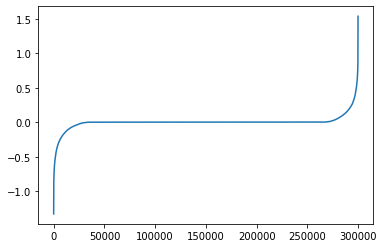

In [5]:
plt.plot(sorted(val_y[:, 2]))

In [64]:
train_x[0][:, 3].max()

0.382026659529361

In [3]:
tf.keras.backend.set_floatx('float64')

model = get_npe_model(max_pairs = 5, state_dim = 6, out_dim = 3, hidden_size = 100)
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0003)

def vel_loss(ytrue, ypred):
    return 1e1 * tf.keras.losses.MSE(ytrue[..., :2], ypred[..., :2])

def ang_loss(ytrue, ypred):
#     return -tf.math.cos(ytrue[..., 2] * 2 * np.pi - ypred[..., 2] * 2 * np.pi)
    return 1e1 / 7.0 * tf.keras.losses.MSE(ytrue[..., 2], ypred[..., 2])
    
def loss(ytrue, ypred):
    return (vel_loss(ytrue, ypred) + ang_loss(ytrue, ypred))


model.compile(loss=loss, metrics=[vel_loss, ang_loss], optimizer=opt)

In [55]:
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=30, batch_size=200, shuffle=True)

Train on 3000000 samples, validate on 300000 samples
Epoch 1/30
3000000/3000000 [==============================] - 195s 65us/sample - loss: 0.0172 - vel_loss: 0.0081 - ang_loss: 0.0091 - val_loss: 0.0180 - val_vel_loss: 0.0081 - val_ang_loss: 0.0099
Epoch 2/30
3000000/3000000 [==============================] - 196s 65us/sample - loss: 0.0170 - vel_loss: 0.0080 - ang_loss: 0.0090 - val_loss: 0.0169 - val_vel_loss: 0.0078 - val_ang_loss: 0.0091
Epoch 3/30
3000000/3000000 [==============================] - 196s 65us/sample - loss: 0.0169 - vel_loss: 0.0079 - ang_loss: 0.0090 - val_loss: 0.0174 - val_vel_loss: 0.0081 - val_ang_loss: 0.0093
Epoch 4/30
3000000/3000000 [==============================] - 193s 64us/sample - loss: 0.0167 - vel_loss: 0.0078 - ang_loss: 0.0089 - val_loss: 0.0163 - val_vel_loss: 0.0077 - val_ang_loss: 0.0086
Epoch 5/30
3000000/3000000 [==============================] - 194s 65us/sample - loss: 0.0165 - vel_loss: 0.0078 - ang_loss: 0.0088 - val_loss: 0.0163 - val_ve

In [12]:
from experiments.npe.simulate import show_simulation as sso
model = tf.keras.models.load_model('model_zoo/npe_replicate_b50_e57.h5')
outputs = sso(model, draw=True, length=500)

In [10]:
show_simulation(model)

KeyboardInterrupt: 

In [72]:
np.set_printoptions(suppress=True)
train_y[:, 2].max()

8.527227498905328e-15

In [81]:
train_x[0][0]

array([ 0.6734375 ,  0.85546875, -0.20135081,  0.75369077,  0.66306668,
        0.91784411, -0.34994342, -0.7536976 ])

In [26]:
p = model(val_x)

In [30]:
plt.plot(sorted(p[:, 0]))

KeyboardInterrupt: 

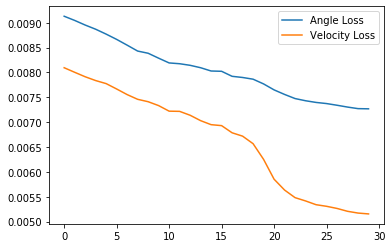

In [60]:
plt.plot(history.history['ang_loss'], label="Angle Loss")
plt.plot(history.history['vel_loss'], label="Velocity Loss")
plt.legend()

In [85]:
from experiments.npe_bt.datagen import collect_data as collect_data_bt
from experiments.npe.datagen import collect_data as collect_data_orig

In [96]:
train_x_orig, train_y_orig = collect_data_orig(
        num_sequences=100,
        sequence_length=60,
        radius=30,
        seed=1337,
    )

100%|██████████| 100/100 [00:00<00:00, 130.59it/s]


In [97]:
train_x_bt, train_y_bt = collect_data_bt(
        num_sequences=100,
        sequence_length=60,
        radius=30,
        seed=1337,
    )

100%|██████████| 100/100 [00:00<00:00, 118.97it/s]


In [98]:
train_x_orig[0]

[array([ 0.6734375 ,  0.85546875, -0.20135081,  0.75369077,  0.66306668,
         0.91784411, -0.34994342, -0.7536976 ]),
 array([0.74882812, 0.70390625, 0.42287457, 0.59242487, 0.78012912,
        0.72550466, 0.57146718, 0.34827979]),
 array([ 0.51328125,  0.75273437, -0.18819043, -0.21944898,  0.4943042 ,
         0.73477623, -0.18819043, -0.21944898]),
 array([1.]),
 array([1.])]

In [99]:
train_x_bt[0]

[array([ 0.6734375 ,  0.85546875, -0.20135081,  0.75369077,  0.        ,
        -0.        ,  0.66306668,  0.91784411, -0.34994342, -0.7536976 ,
        -0.        , -0.        ]),
 array([ 0.74882812,  0.70390625,  0.42287457,  0.59242487,  0.        ,
        -0.        ,  0.78012912,  0.72550466,  0.57146718,  0.34827979,
        -0.        , -0.        ]),
 array([ 0.51328125,  0.75273437, -0.18819043, -0.21944898,  0.        ,
        -0.        ,  0.4943042 ,  0.73477623, -0.18819043, -0.21944898,
        -0.        , -0.        ]),
 array([1.]),
 array([1.])]

In [100]:
train_y_orig[0]

array([0.35546072, 0.31712341])

In [101]:
train_y_bt[0]

array([ 0.35546072,  0.31712341, -0.        ])

In [ ]:
plt.plot()

In [59]:
model.save('model_zoo/block_tower_1.h5')